## Step 1 — 환경 준비 (라이브러리 설치/임포트)
**프로젝트 단계:** 환경 세팅  
**목적:** 재현 가능한 실행 환경을 만들고, 필요한 패키지를 설치/임포트한다.  
**핵심:** `transformers`, `datasets`, `evaluate`, `torch`, (Colab이면) `tf-keras` 설치.

In [22]:
# !pip install tensorflow
# !pip install transformers
# !pip install datasets
# !pip install evaluate
# !pip install tf-keras

# !pip install transformers[torch]
# !pip install torch==2.7.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.5 MB/s eta 0:00:00


## Step 2 — 데이터셋 로드 & 버전 확인
**프로젝트 단계:** 데이터 준비  
**목적:** NSMC(`Blpeng/nsmc`)를 로드하고, 주요 패키지 버전을 출력해 재현성을 확보한다.  
**핵심:** `load_dataset("Blpeng/nsmc")`, `numpy/transformers/datasets/torch` 버전 로그.

In [3]:
#import tensorflow
import numpy
import transformers
import datasets
import torch
import matplotlib.pyplot as plt

#허깅페이스 Blpeng/NSMC데이터셋을 로드
from datasets import load_dataset

ds = load_dataset("Blpeng/nsmc")

#print(tensorflow.__version__)
print(numpy.__version__)
print(transformers.__version__)
print(datasets.__version__)
print(torch.__version__)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


ratings_train.csv:   0%|          | 0.00/15.7M [00:00<?, ?B/s]

ratings_test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/150000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

2.0.2
4.56.1
4.0.0
2.8.0+cu126


## Step 3 — 디바이스 확인(GPU/CPU)
**프로젝트 단계:** 환경 점검  
**목적:** 현재 런타임이 CUDA를 사용할 수 있는지 확인하고, `device`를 설정한다.  
**핵심:** `torch.cuda.is_available()`, `device = cuda or cpu`.

In [2]:
import torch
print(torch.cuda.is_available())
#device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

True
Using device: cuda


## Step 4 — 모델/토크나이저 초기화
**프로젝트 단계:** 모델 준비  
**목적:** `klue/bert-base` 토크나이저/모델을 이진분류 헤드(`num_labels=2`)로 로드한다.  
**핵심:** `AutoTokenizer.from_pretrained`, `AutoModelForSequenceClassification(..., num_labels=2)`.

In [3]:
#모델을 직접 로드
from transformers import AutoTokenizer, AutoModelForMaskedLM
from transformers import AutoModelForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
#model = AutoModelForMaskedLM.from_pretrained("klue/bert-base")

#이진분류를 위한 모델 클래스 변경
model_name = "klue/bert-base"
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Step 5 — 데이터 스키마/결측 확인
**프로젝트 단계:** 데이터 탐색(EDA)  
**목적:** 스플릿별 컬럼/결측 여부를 점검하고, 전처리 필요성을 확인한다.  
**핵심:** `Dataset.to_pandas().info()`로 결측 존재 확인.

In [8]:
import pandas as pd

def inspect_columns_with_info(dataset_dict):
    """
    Hugging Face DatasetDict의 각 스플릿을 Pandas DataFrame으로 변환하고,
    .info() 메소드를 사용해 결측값 존재를 추정합니다.
    """
    print("Pandas .info()를 사용한 컬럼 정보 확인을 시작합니다.\n")

    for split_name, dataset in dataset_dict.items():
        print(f"--- {split_name.upper()} 데이터셋 ---")

        # 데이터셋을 Pandas DataFrame으로 변환
        df = dataset.to_pandas()

        df.info()

        print("\n")

def filter_nulls(example):
    return example['document'] is not None and len(example['document']) > 0

inspect_columns_with_info(ds)

Pandas .info()를 사용한 컬럼 정보 확인을 시작합니다.

--- TRAIN 데이터셋 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  150000 non-null  int64 
 1   id          150000 non-null  int64 
 2   document    149995 non-null  object
 3   label       150000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.6+ MB


--- TEST 데이터셋 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  50000 non-null  int64 
 1   id          50000 non-null  int64 
 2   document    49997 non-null  object
 3   label       50000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB




결측치가 존재함을 확인
따라서 전처리를 진행하며 결측치를 제거

## Step 6 — 전처리 설계 & 함수 구현
**프로젝트 단계:** 데이터 전처리  
**목적:** 텍스트를 정규화하여 학습 안정성을 높인다.  
**핵심:**  
- 결측치 처리(빈 문자열 대체)  
- 허용 문자 필터(한글/영문/숫자/기본 구두점)  
- 반복 감정표현(`ㅋ/ㅎ/ㅠ/ㅜ`) **길이 2로 제한**  
- 공백 정규화  
- 토크나이즈(`truncation=True`, `padding=False`)


In [9]:
import re

def preprocess(dataset) :
    cleaned_texts = []
    for text in dataset['document'] :

        #결측치 제거
        if text is None :
            text = ""
        #한글, 특수문자, 중복띄어쓰기, 제거
        text = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9\s.?!,()]', '', text)
        #리뷰 특성상 감정표현을 위해 ㅋ,ㅎ,ㅠ,,ㅜ등이 반복되는 사례가 많음 따라서 2번으로 제한
        text = re.sub(r'([ㅋㅎㅜㅠ]){4,}', r'\1\1', text)
        #공백 정규화
        text = ' '.join(text.split())

        cleaned_texts.append(text)

    return tokenizer(
        cleaned_texts,
        truncation=True,
        padding=False
    )

In [18]:
#데이터 전처리
ds = ds.filter(filter_nulls)
dataset = ds.map(preprocess, batched=True)
inspect_columns_with_info(dataset)

# train & test
train_dataset = dataset['train']
test_dataset = dataset['test']

#test에서 validation 분할
train_val_split = train_dataset.train_test_split(test_size=0.1)

#분할된 셋을 각 변수에 할당
train_dataset = train_val_split['train']
val_dataset = train_val_split['test']

Filter:   0%|          | 0/149995 [00:00<?, ? examples/s]

Filter:   0%|          | 0/49997 [00:00<?, ? examples/s]

Map:   0%|          | 0/149995 [00:00<?, ? examples/s]

Map:   0%|          | 0/49997 [00:00<?, ? examples/s]

Pandas .info()를 사용한 컬럼 정보 확인을 시작합니다.

--- TRAIN 데이터셋 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149995 entries, 0 to 149994
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      149995 non-null  int64 
 1   id              149995 non-null  int64 
 2   document        149995 non-null  object
 3   label           149995 non-null  int64 
 4   input_ids       149995 non-null  object
 5   token_type_ids  149995 non-null  object
 6   attention_mask  149995 non-null  object
dtypes: int64(3), object(4)
memory usage: 8.0+ MB


--- TEST 데이터셋 ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49997 entries, 0 to 49996
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      49997 non-null  int64 
 1   id              49997 non-null  int64 
 2   document        49997 non-null  object
 3   label           49997 non

In [19]:
#data collator

from transformers import DataCollatorWithPadding

# 이전에 생성한 tokenizer를 사용
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)






위 문제점을 기반으로 가설 생성
## Step 7 — 문제점 요약 & 가설 명시
**프로젝트 단계:** 실험 설계  
**이슈:**
팀원들의 실험결과들을 통해 문제점 예측
1. 기존 학습규제들은 빠른 과적합을 불러일으킴
2. LoRA를 이용해 과적합을 방지하고 학습속도를 올리려 하였지만, 파라미터 수가 너무 적어 과소적합이 일어남

**핵심:** “과적합을 늦추고 일반화 성능을 극대화한다”를 상위 목표로 잡음.


## Step 10 — 학습 설정(TrainingArguments)
**프로젝트 단계:** 학습 전략 설정  
**목적:** 로깅/평가/저장/스케줄/배치/정규화 등 학습 전략을 정의한다.  
**핵심:**  
- 로깅/평가 간격: **step 단위 2,000** (`logging_steps=2000`, `eval_steps=2000`)  
- 체크포인트: `save_total_limit`, (TensorBoard) `report_to="tensorboard"`  
- 워밍업/스케줄: `warmup_steps=500`, `warmup_ratio=0.06`  
- 최적화: `learning_rate=2e-5`, `weight_decay=0.1`, `num_train_epochs=6`  
- 배치: `per_device_train_batch_size=16`, `gradient_accumulation_steps=2`(효과적 배치 32)  
- 혼합정밀: `fp16=True`, 재현성: `seed=42`  


팀원들의 arg를 바탕으로 종합적인 arg를 셋팅


In [27]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
from google.colab import drive

drive.mount('/content/drive')
output_dir = '/content/drive/MyDrive/Colab_Results/nsmc_model'

training_arguments = TrainingArguments(
    output_dir,                        # output이 저장될 경로

    #시각화를 위한 셋팅
    logging_strategy="steps",            # step 단위로 로그 저장
    logging_steps=2000,                  # 2000 step마다 로그 저장
    eval_strategy="steps",               # step 단위로 검증 진행
    eval_steps=2000,                     # 2000 step마다 검증 진행
    save_strategy="steps",               # step 단위로 모델 저장
    save_steps=2000,                     # 2000 step마다 모델 저장
    load_best_model_at_end=True,

    #추가 하이퍼파라미터
    lr_scheduler_type='linear',          # 선형 학습률 스케줄러 사용
    warmup_steps=500,                    # 훈련 초기 500 step 동안 학습률을 서서히 증가
    warmup_ratio=0.06,
    metric_for_best_model='f1',          # 훈련 초기 500 step 동안 학습률을 서서히 증가
    greater_is_better=True,              # metric_for_best_model의 값이 클수록 좋다고 명시 (필수)
    fp16=True,                           # 학습 속도 및 메모리 효율 향상
    report_to="tensorboard",             # TensorBoard로 로그 리포팅
    seed = 42,


    learning_rate = 2e-5,                 #learning_rate
    per_device_train_batch_size = 16,      # 각 device 당 batch size
    per_device_eval_batch_size = 16,       # evaluation 시에 batch size
    gradient_accumulation_steps=2,
    num_train_epochs = 6,                 # train 시킬 총 epochs
    weight_decay = 0.1,                  # weight decay
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import numpy
import evaluate

#이진 분류를 위해 지표들을 combine
metric = evaluate.combine(["accuracy", "f1", "precision", "recall"])



def compute_metrics(eval_pred):
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

## Step 12 — Trainer 초기화 & 학습 실행
**프로젝트 단계:** 학습  
**목적:** 설정한 전략과 지표로 훈련을 수행하고, 과적합을 방지한다.  
**핵심:**  
- `Trainer(model, args, train_dataset, eval_dataset, data_collator, compute_metrics)`  
- **EarlyStopping**: `patience=3`, `threshold=0.001`  
- 산출: 체크포인트(`checkpoint-XXXX`), TensorBoard 로그(`runs/`)

In [28]:
trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=train_dataset,    # training dataset
    eval_dataset=val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)],
)
trainer.train()


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
2000,0.330400,0.267878,0.887600,0.885555,0.899848,0.871709
4000,0.260400,0.252367,0.900533,0.900467,0.899028,0.901911
6000,0.195400,0.253012,0.904600,0.903278,0.913840,0.892957
8000,0.187900,0.272078,0.900200,0.900723,0.894023,0.907524
10000,0.142100,0.297329,0.902933,0.902387,0.905422,0.899372
12000,0.125700,0.327980,0.902133,0.902588,0.896402,0.908860


TrainOutput(global_step=12000, training_loss=0.2069769287109375, metrics={'train_runtime': 1845.5265, 'train_samples_per_second': 438.883, 'train_steps_per_second': 13.716, 'total_flos': 1.233120630378348e+16, 'train_loss': 0.2069769287109375, 'epoch': 2.844275894761792})

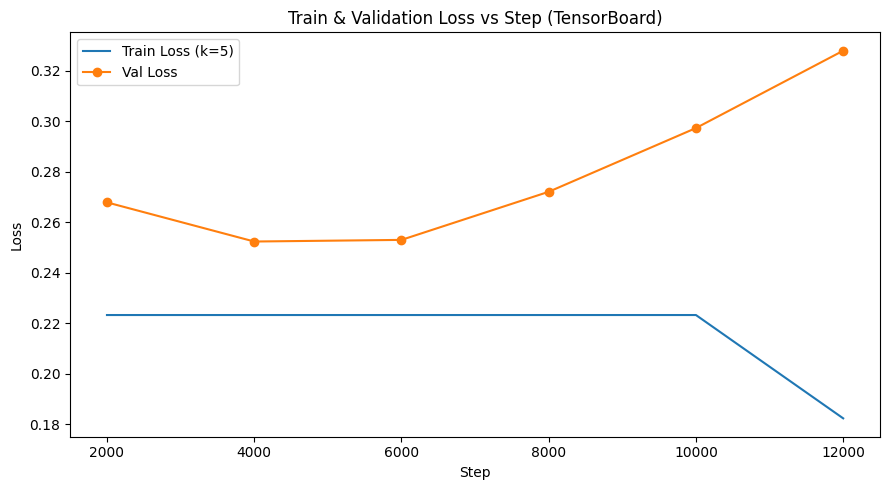

In [12]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def tb_series(runs_dir):
    series = {}  # tag -> dict(step->val)
    event_files = glob.glob(os.path.join(runs_dir, "**", "events.out.tfevents.*"), recursive=True)
    if not event_files:
        raise FileNotFoundError("runs/ 아래 TensorBoard 이벤트 파일을 찾지 못했습니다.")

    for f in event_files:
        ea = EventAccumulator(f); ea.Reload()
        for tag in ea.Tags().get("scalars", []):
            if tag not in series:
                series[tag] = {}
            for e in ea.Scalars(tag):
                series[tag][e.step] = float(e.value)  # 중복 step은 마지막 값으로 덮어씀
    # 정렬된 리스트로 변환
    return {tag: sorted(d.items()) for tag, d in series.items()}

def first_available(series, candidates):
    for t in candidates:
        if t in series and len(series[t])>0:
            return t
    return None

def plot_train_val_loss_from_tb(runs_dir, smooth_k=1, save_path=None):
    s = tb_series(runs_dir)
    # 태그 후보 (환경/버전에 따라 다를 수 있음)
    train_tag = first_available(s, ["train/loss","loss","training_loss"])
    val_tag   = first_available(s, ["eval/loss","eval_loss"])

    if not train_tag and not val_tag:
        print("train/eval loss 태그를 찾지 못했습니다.")
        return

    plt.figure(figsize=(9,5))

    if train_tag:
        t_steps, t_vals = zip(*s[train_tag])
        if smooth_k>1:
            # 이동평균(길이 맞춤용 간단 패딩)
            t_vals = np.array(t_vals)
            k = smooth_k
            if len(t_vals) >= k:
                t_vals_s = np.convolve(t_vals, np.ones(k)/k, mode="valid")
                t_vals_s = np.r_[np.full(k-1, t_vals_s[0]), t_vals_s]
            else:
                t_vals_s = t_vals
            plt.plot(t_steps, t_vals_s, label=f"Train Loss (k={smooth_k})")
        else:
            plt.plot(t_steps, t_vals, label="Train Loss")

    if val_tag:
        v_steps, v_vals = zip(*s[val_tag])
        plt.plot(v_steps, v_vals, label="Val Loss", marker="o", linestyle="-")

    # (선택) eval/loss 최고가 아닌 '최저'가 베스트이므로, 다른 지표로 best_step 표시하고 싶으면 여기에 추가
    plt.title("Train & Validation Loss vs Step (TensorBoard)")
    plt.xlabel("Step"); plt.ylabel("Loss")
    plt.legend(); plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=150)
    plt.show()

# 사용 예시:
runs_dir = "/content/drive/MyDrive/Colab_Results/nsmc_model/runs"
plot_train_val_loss_from_tb(runs_dir, smooth_k=5, save_path="train_val_loss_tb.png")

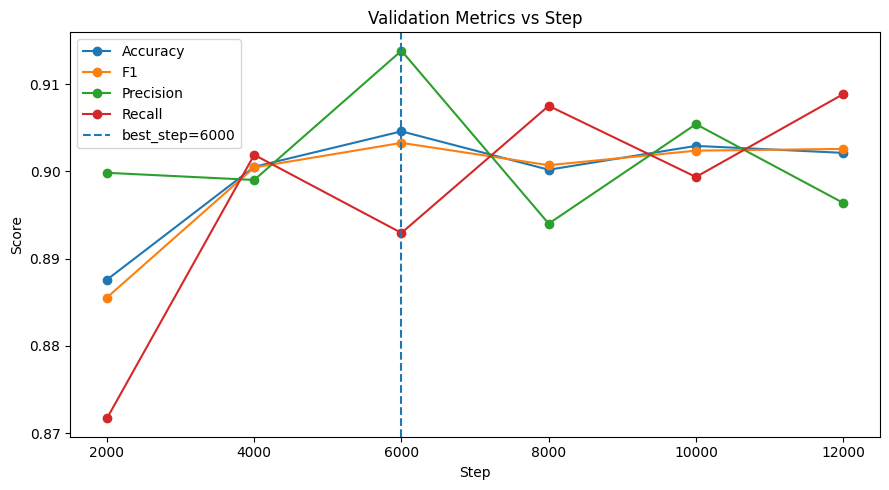

In [13]:
# 필요한 패키지
# !pip install tensorboard  # Colab엔 보통 기본 설치

import os, glob, numpy as np
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# 여러분의 경로로 설정
runs_dir = "/content/drive/MyDrive/Colab_Results/nsmc_model/runs"

def load_tb_scalars(runs_dir):
    """runs/ 아래 모든 tfevents에서 scalar 태그를 수집: tag -> [(step, value), ...]"""
    series = {}
    event_files = glob.glob(os.path.join(runs_dir, "**", "events.out.tfevents.*"), recursive=True)
    if not event_files:
        raise FileNotFoundError("TensorBoard 이벤트 파일을 찾지 못했습니다. report_to='tensorboard'로 학습되었는지 확인하세요.")
    for f in event_files:
        ea = EventAccumulator(f); ea.Reload()
        for tag in ea.Tags().get("scalars", []):
            if tag not in series:
                series[tag] = {}
            for e in ea.Scalars(tag):
                # 같은 step이 여러 파일에 있을 수 있어 마지막 값을 채택
                series[tag][e.step] = float(e.value)
    # step 오름차순으로 정렬된 리스트로 변환
    return {tag: sorted(step2val.items()) for tag, step2val in series.items()}

def first_available(series, candidates):
    """후보 태그들 중 실제로 존재하는 첫 태그 반환"""
    for t in candidates:
        if t in series and len(series[t]) > 0:
            return t
    return None

# 1) 로그 적재
series = load_tb_scalars(runs_dir)

# 2) 검증 지표 태그(환경/버전에 따라 이름이 달라질 수 있어 후보군 준비)
candidates = {
    "Accuracy":  ["eval/accuracy", "eval_accuracy", "accuracy"],
    "F1":        ["eval/f1", "eval_f1", "f1"],
    "Precision": ["eval/precision", "eval_precision"],
    "Recall":    ["eval/recall", "eval_recall"],
}

# 3) 플롯에 쓸 (지표이름 -> (steps, values)) 구성
plot_data = {}
for name, cand in candidates.items():
    tag = first_available(series, cand)
    if tag:
        xs, ys = zip(*series[tag])
        plot_data[name] = (xs, ys)

if not plot_data:
    raise RuntimeError("검증 지표 태그를 찾지 못했습니다. (예: eval/accuracy, eval/f1 등)")

# 4) 베스트 스텝(있으면) 계산: F1 우선, 없으면 Accuracy 기준
best_step = None
if "F1" in plot_data:
    xs, ys = plot_data["F1"]
    best_step = xs[int(np.argmax(ys))]
elif "Accuracy" in plot_data:
    xs, ys = plot_data["Accuracy"]
    best_step = xs[int(np.argmax(ys))]

# 5) 한 그래프에 검증 지표 전부 그리기
plt.figure(figsize=(9,5))
for name, (xs, ys) in plot_data.items():
    # 검증 포인트는 간격이 넓은 경우가 많아 마커를 주면 식별이 쉬움
    plt.plot(xs, ys, marker="o", linestyle="-", label=name)

if best_step is not None:
    plt.axvline(best_step, linestyle="--", label=f"best_step={best_step}")

plt.title("Validation Metrics vs Step")
plt.xlabel("Step")
plt.ylabel("Score")  # (Accuracy/F1/Precision/Recall은 0~1 범위)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
메트릭 변화 추이를 확인한 결과
6000step 근방에서 precision이 높고 recall이 낮아
일반화의 최고점이라고 볼 수 있다.

팀원들의 결과에서는 대부분의 메트릭이 90을 넘지 못하거나
넘기더라도 훨씬 많은 스텝을 수행해야 했지만 지금의 설정은 기존보다 적은 학습으로도 높은 퍼포먼스를 보여줄 수 있었다.




회고
허깅페이스의 모델과 데이터셋을 이용하면 기존에 진행했던 프로젝트 방식들보다 훨씬 편하게 프로젝트를 진행할 수 있는걸 알았다. 기존 프로젝트에서 못했던 레포트화를 하기 위해 노력해봤으며 시각화를 열심히 해봤지만 생각보다 아쉬운 결과를 본것같다.